<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

### Install and import libraries

In [65]:
%%capture
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install shap
!pip install bokeh holoviews colorcet scikit-image datashader
!pip install optuna
!pip install optuna-integration

In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.gridspec as gridspec
import shap
import umap
import umap.plot
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import warnings
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, balanced_accuracy_score


pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Preprocessed Data

In [67]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1oytLt6WKLGciX1W34zBkwQ-9CBWtFe-d'
file_name = 'selected_features_80.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_data = pd.read_csv(file_name)
selected_features_data.shape

(58976, 81)

In [68]:
selected_features_data.head()

,Procedure: Surgical Suture and Repair,"Creatine Kinase, MB Isoenzyme",Bands,Lipase,Iron,Procedure: Facial and Thoracic Surgery,"Bilirubin, Total",Procedure: Cranial and Peripheral Interventions,Eosinophils,"Fibrinogen, Functional",ADMISSION_TYPE_ELECTIVE,"Chloride, Whole Blood",Procedure: External Device and Eyelid Repair,"Iron Binding Capacity, Total",Red Blood Cells,Procedure: Gastric Procedure and Vascular Revision,"Sodium, Whole Blood",Monocytes,Transferrin,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,Hematocrit,Procedure: Spinal and Abdominal Surgery,Vancomycin,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Alanine Aminotransferase (ALT),Procedure: Structural and Bone Biopsy,Procedure: Lung Biopsy and Intervention,"Potassium, Whole Blood",ADMISSION_TYPE_NEWBORN,Lactate Dehydrogenase (LD),pCO2,Urobilinogen,pO2,Procedure: Arterial Imaging and Debridement,pH,Anion Gap,Asparate Aminotransferase (AST),Free Calcium,Calculated Total CO2,ETHNICITY_WHITE,PT,Alkaline Phosphatase,Lactate,DIAGNOSIS_NEWBORN,Procedure: Knee and Spinal Surgery,MCV,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,White Blood Cells,Hyaline Casts,Platelet Count,MCH,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,RDW,MCHC,INR(PT),Magnesium,Creatine Kinase (CK),Neutrophils,Lymphocytes,Bicarbonate,Procedure: Injections and Therapeutic Procedures,"Calcium, Total",Glucose,Potassium,PTT,Procedure: Catheterization and Ventilation Techniques,Troponin T,Procedure: Contrast Imaging and Spleen Procedures,Phosphate,Chloride,Sodium,Albumin,Creatinine,GENDER_F,Urea Nitrogen,GENDER_M,ADMISSION_TYPE_EMERGENCY,AGE_AT_ADMISSION,RBC,WBC,uti
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1.0,1.0,1.0,0,1.0,0.0,0.0,1.0,0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,0,1.0,1.0,0,1.0,0.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1,1,63.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,1.0,0.0,0,1.0,1.0,0,1.0,0.0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1.0,1,1,64.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0.0,1.0,0,1.0,1.0,0.0,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,1.0,0,1,85.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1,1.0,0,1,59.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0,0.0,1.0,0,0.0,0.0,0.0,1.0,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1.0,0,1,87.0,1.0,0.0,1.0


In [69]:
selected_features_data['uti'] = selected_features_data['uti'].replace({True: 1, False: 0})

In [70]:
selected_features_df = selected_features_data

In [108]:
#selected_features_df = selected_features_data.drop(['HADM_ID'], axis=1)

### Train Test Val Split

In [8]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [9]:
# Scale data
StdScaler = StandardScaler()
X_train_scaled = StdScaler.fit_transform(X_train)
X_val_scaled = StdScaler.transform(X_val)
X_test_scaled = StdScaler.transform(X_test)

## Functions for Model Evaluation

In [ ]:
def evaluate_classification(model, X, y):
    """
    Evaluates a classification model and returns AUC, Sensitivity, Specificity, Accuracy, and Balanced Accuracy.

    Parameters:
    - model: Trained classification model.
    - X: Input features.
    - y: True labels.

    Returns:
    - Dictionary containing the evaluation metrics.
    """
    # Get predictions
    predictions = model.predict(X)

    # Calculate probabilities for the positive class
    probabilities = model.predict_proba(X)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y, probabilities)

    # Calculate confusion matrix for Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)

    # Specificity
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(y, predictions)

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y, predictions)

    metrics = {
        'AUC': auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc
    }

    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.2f}")

    return metrics


def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# define labels
labels = ['non-UTI', 'UTI']

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

### Neural Network + Encoder + UMAP

 DNN for binary classification that also provide an encoding of the input through model_encoder

In [10]:
# Define the neural network architecture
def build_model(input_shape):
    x = inp = Input(shape=input_shape)

    # Create hidden layers
    for _ in range(3):
        x = Dense(64, activation='swish')(x)
        x = Dropout(0.2)(x)

    out_encoder = Dense(64)(x)
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out), Model(inputs=inp, outputs=out_encoder)

# Compute sample weights for class balancing
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Create and compile the model
model, model_encoder = build_model([80])
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64,
                    validation_data=(X_val_scaled, y_val),
                    sample_weight=sample_weights,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 5s 4ms/step - loss: 0.5104 - accuracy: 0.7066 - val_loss: 0.5019 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4745 - accuracy: 0.7443 - val_loss: 0.4708 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4671 - accuracy: 0.7498 - val_loss: 0.4930 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4624 - accuracy: 0.7538 - val_loss: 0.4590 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4581 - accuracy: 0.7567 - val_loss: 0.4691 - val_accuracy: 0.7587 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4511 - accuracy: 0.7606 - val_loss: 0.4557 - val_accuracy: 0.7671 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [11]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     10463
         1.0       0.31      0.78      0.44      1333

    accuracy                           0.78     11796
   macro avg       0.64      0.78      0.65     11796
weighted avg       0.89      0.78      0.81     11796



In [12]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.07% - Balanced accuracy Test
82.71% - Balanced accuracy Train


**UMAP and Agglomerative clustering**

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [13]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled).numpy()
Xenc_test = model_encoder(X_test_scaled)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(8, 6927), (142, 2160), (11, 480), (7, 199), (18, 146), (0, 141), (16, 134), (35, 116), (33, 115), (3, 95)]
[(142, 1338), (7, 162), (0, 111), (35, 92), (16, 91), (13, 50), (43, 42), (19, 28), (71, 27), (45, 22)]


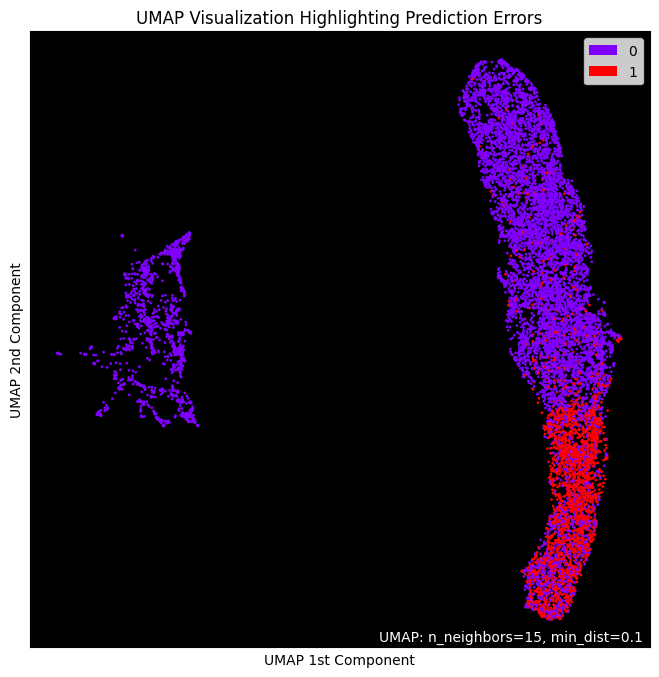

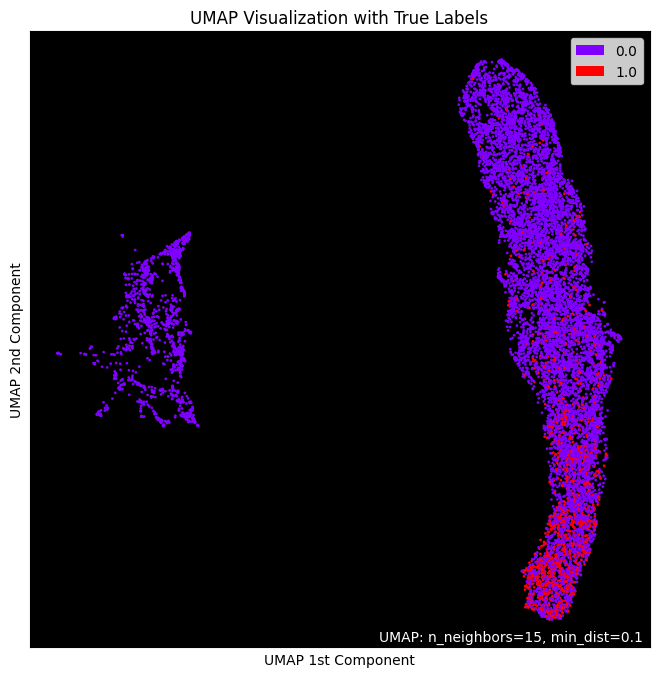

In [14]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

Permutation Importance

In [15]:
def permutation_importance(model, X_val_scaled, y_val, metric=accuracy_score):
    """
    Calculate permutation importance for a given model and validation set.

    Parameters:
    - model: Trained model
    - X_val: Validation data (features)
    - y_val: True labels for validation data
    - metric: Performance metric function

    Returns:
    - importances: Feature importance scores
    """
    feature_names = X.columns.tolist()

    # Get the original performance of the model
    original_preds = model.predict(X_val_scaled)
    # Convert predictions to binary values
    original_preds_binary = (original_preds > 0.5).astype(int)
    original_score = metric(y_val, original_preds_binary)

    # Calculate permutation importance for each feature
    importances = []
    for col in range(X_val_scaled.shape[1]):
        X_val_copy = X_val_scaled.copy()
        np.random.shuffle(X_val_copy[:, col])
        shuffled_preds = model.predict(X_val_copy, verbose=0)
        shuffled_preds_binary = (shuffled_preds > 0.5).astype(int)
        shuffled_score = metric(y_val, shuffled_preds_binary)
        importances.append(original_score - shuffled_score)

    return np.array(importances)

feature_names = X.columns.tolist()

# Calculate permutation importance
feature_importances = permutation_importance(model, X_val_scaled, y_val)

# Pair feature names with their importances
feature_importance_pairs = list(zip(feature_names, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display feature importances in descending order
for name, imp in sorted_feature_importance_pairs:
    print(f"Feature {name}: {imp}")


295/295 [==============================] - 0s 1ms/step
Feature WBC: 0.062102585841458224
Feature RBC: 0.009220008478168729
Feature ADMISSION_LOCATION_EMERGENCY ROOM ADMIT: 0.005192878338278972
Feature Free Calcium: 0.004768969902501086
Feature pH: 0.004451038575667643
Feature Vancomycin: 0.003179313268333983
Feature Fibrinogen, Functional: 0.0028613819415006514
Feature Asparate Aminotransferase (AST): 0.0028613819415006514
Feature MCV: 0.0028613819415006514
Feature Bilirubin, Total: 0.0027554048325562075
Feature Hyaline Casts: 0.0027554048325562075
Feature ADMISSION_TYPE_EMERGENCY: 0.0026494277236116526
Feature Procedure: Lung Biopsy and Intervention: 0.0025434506146672087
Feature Urobilinogen: 0.002331496396778321
Feature pO2: 0.002331496396778321
Feature Bands: 0.002225519287833766
Feature Procedure: Knee and Spinal Surgery: 0.002119542178889322
Feature Red Blood Cells: 0.002013565069944878
Feature Procedure: Spinal and Abdominal Surgery: 0.002013565069944878
Feature ADMISSION_LOCATI

## Optuna - Hyperparameter Search

Using Optuna to optimize the hyperparameters of neural network

```python
def objective(trial):
    # Hyperparameters to be optimized
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.8)  # increasing max dropout
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)  # increasing max layers
    optimizer_selected = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD', 'Adagrad'])
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'swish', 'tanh', 'elu', 'selu'])
    weight_initializer = trial.suggest_categorical('weight_initializer', ['glorot_uniform', 'he_uniform', 'lecun_uniform'])
    
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_layer_0', 8, 256, log=True),
                    input_shape=(X_train_scaled.shape[1],), activation=activation, kernel_initializer=weight_initializer))
    
    for i in range(1, num_hidden_layers + 1):
        model.add(Dense(trial.suggest_int(f'units_layer_{i}', 8, 256, log=True), activation=activation, kernel_initializer=weight_initializer))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer_selected == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_selected == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=batch_size,
                        sample_weight=sample_weights, validation_data=(X_val_scaled, y_val), verbose=0,
                        callbacks=[early_stopping, lr_scheduler, TFKerasPruningCallback(trial, 'val_accuracy')])
    
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Using pruning
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=200, timeout=7200)  # increased the number of trials

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
```

```
Number of finished trials:  131
Best trial:
  Value: 0.889147937297821
  Params:
    dropout_rate: 0.3805232216149589
    num_hidden_layers: 5
    optimizer: RMSprop
    learning_rate: 0.006383910844339045
    batch_size: 16
    activation: tanh
    weight_initializer: lecun_uniform
    units_layer_0: 176
    units_layer_1: 34
    units_layer_2: 65
    units_layer_3: 17
    units_layer_4: 15
    units_layer_5: 14
```

```python
def build_model(hyperparams):
    model = Sequential()

    # Input layer
    model.add(Dense(hyperparams['units_layer_0'], input_shape=(X_train_scaled.shape[1],), activation=hyperparams['activation'], kernel_initializer=hyperparams['weight_initializer']))
    
    # Hidden layers
    for i in range(hyperparams['num_hidden_layers']):
        model.add(Dense(hyperparams[f'units_layer_{i}'], activation=hyperparams['activation'], kernel_initializer=hyperparams['weight_initializer']))
        model.add(Dropout(hyperparams['dropout_rate']))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    if hyperparams['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])
    elif hyperparams['optimizer'] == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hyperparams['learning_rate'])
    elif hyperparams['optimizer'] == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=hyperparams['learning_rate'])
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hyperparams['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Get best hyperparameters from the Optuna study
best_hyperparams = trial.params

# Build the model
best_model = build_model(best_hyperparams)

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model using the best batch size from Optuna study
history = best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=best_hyperparams['batch_size'],
                         sample_weight=sample_weights, validation_data=(X_val_scaled, y_val),
                         callbacks=[early_stopping, lr_scheduler])

```

```
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     10463
         1.0       0.38      0.59      0.47      1333

    accuracy                           0.85     11796
   macro avg       0.66      0.74      0.69     11796
weighted avg       0.88      0.85      0.86     11796

[51]
0s
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")
output
73.67% - Balanced accuracy Test
74.56% - Balanced accuracy Train
```

## Deep Neural Network (DNN)

In [16]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val_scaled, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 5s 5ms/step - loss: 0.5447 - accuracy: 0.6947 - val_loss: 0.4624 - val_accuracy: 0.7652 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4912 - accuracy: 0.7384 - val_loss: 0.4466 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4778 - accuracy: 0.7376 - val_loss: 0.4359 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4686 - accuracy: 0.7472 - val_loss: 0.4683 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4618 - accuracy: 0.7410 - val_loss: 0.4661 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 3ms/step - loss: 0.4589 - accuracy: 0.7466 - val_loss: 0.4522 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                5184      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1

Plot Learning Curves

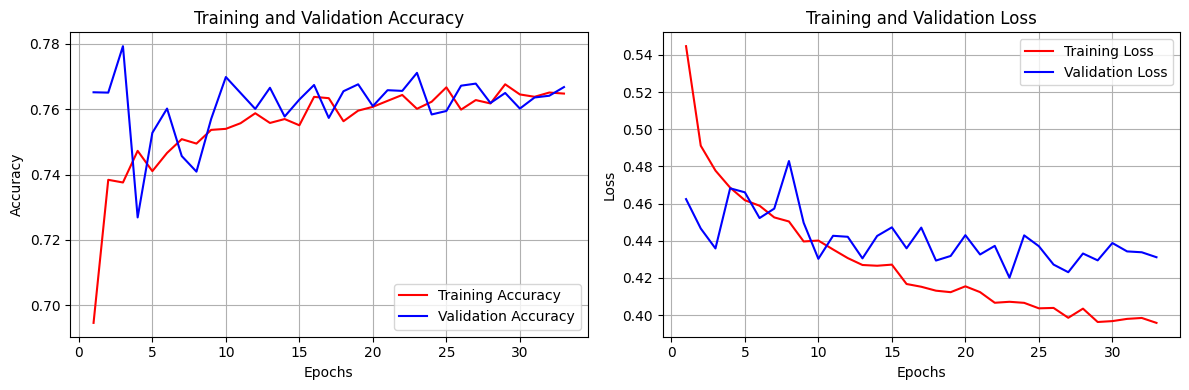

In [19]:
plot_learning_curves(history)

**DNN Model Evaluation**

In [20]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [21]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     10463
         1.0       0.30      0.81      0.44      1333

    accuracy                           0.77     11796
   macro avg       0.64      0.78      0.65     11796
weighted avg       0.89      0.77      0.81     11796



In [22]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.46% - Balanced accuracy Test
83.42% - Balanced accuracy Train


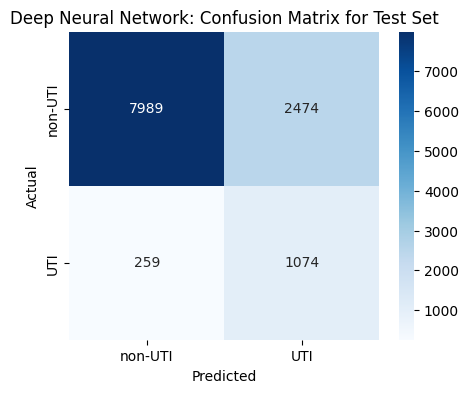

In [24]:
plot_confusion_matrix(y_test, dnn_y_test_pred.round(), title='Deep Neural Network: Confusion Matrix for Test Set')

369/369 [==============================] - 1s 1ms/step


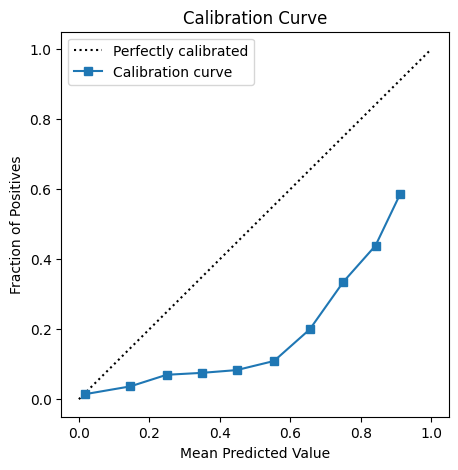

In [25]:
# calibration curve
dnn_y_test_pred = model.predict(X_test_scaled)
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated").

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


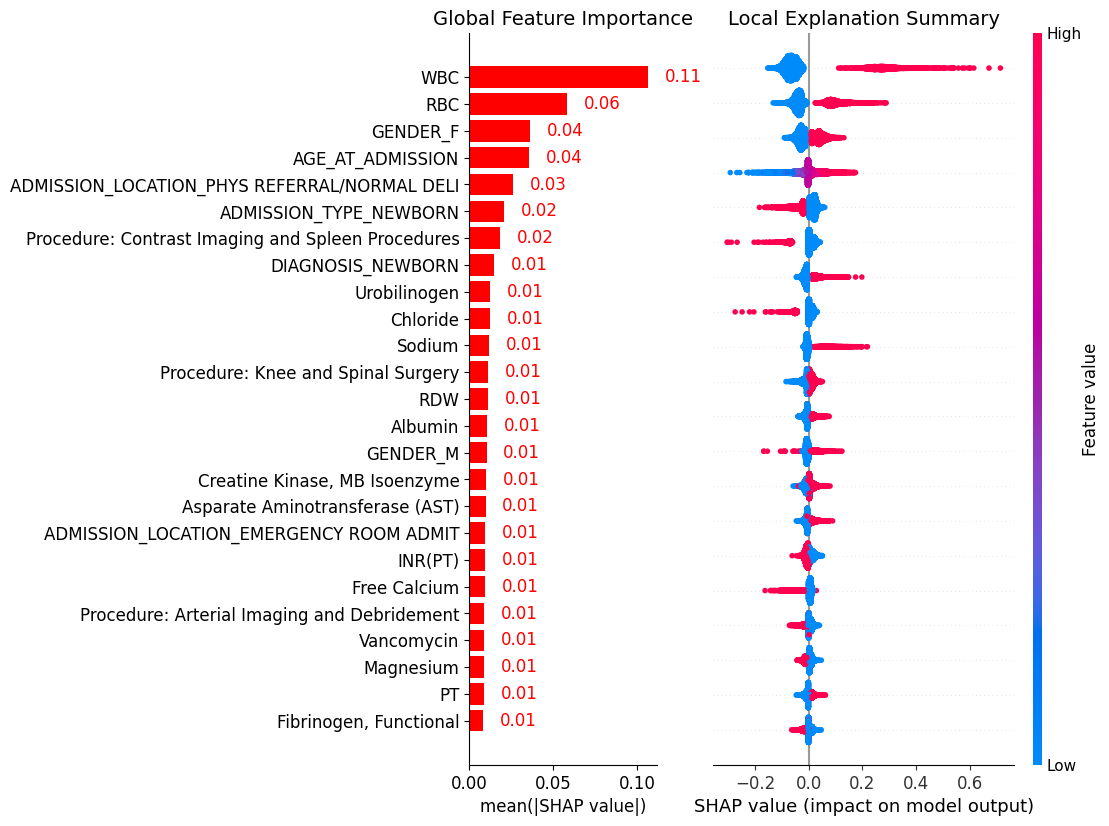

In [26]:
## SHAP

# Get feature names
feature_names = X.columns.tolist()

X_train_scaled = X_train_scaled.astype(np.float32)
random_indices = np.random.choice(X_train_scaled.shape[0], size=1000, replace=False)
subset_data = X_train_scaled[random_indices]

# Compute SHAP values for a particular set (e.g., test set)
# Using DeepExplainer for Deep Neural Network model:
explainer = shap.DeepExplainer(model, subset_data)
shap_values = explainer.shap_values(X_test_scaled)

# The first set of values from the list of shap_values for binary classification
shap_values_array = shap_values[0]

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-25:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[:, sorted_indices]

# Create a combined plot with subplots using GridSpec for layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)
ax1.set_title('Global Feature Importance', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar with red color
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)

# Plot typical SHAP values on right
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

## Attention with DNN

feed-forward neural network with an attention mechanism in the middle

- input layer
- 2 dense layer
- attention
- output layer

In [91]:
# OPTUNA

import optuna
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import compute_sample_weight

def objective(trial):

    # Define hyperparameters space using optuna trial
    hidden_units = trial.suggest_int("hidden_units", 64, 512, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    attention_size = trial.suggest_int("attention_size", 32, 128, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128, log=True)

    # Model architecture with suggested hyperparameters
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_units, activation='swish')(inputs)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Dense(hidden_units, activation='swish')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Dense(hidden_units, activation='swish')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Dense(hidden_units, activation='swish')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = attention_mechanism(x, attention_size)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping for efficient tuning
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Model training
    model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.1,
        sample_weight=sample_weights,
        callbacks=[early_stop, lr_scheduler],
        verbose=0
    )

    # Predictions and metric evaluation
    y_pred = model.predict(X_val_scaled).ravel()
    y_pred_class = np.where(y_pred > 0.5, 1, 0)
    return 1.0 - balanced_accuracy_score(y_val, y_pred_class)

# Initiate Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # number of trials can be adjusted

# Print results
print(f"Best trial score: {1-study.best_value:.4f}")
print("Best hyperparameters:")
print(study.best_params)



[I 2023-10-09 07:21:03,256] A new study created in memory with name: no-name-94f5ab89-cf39-49b0-952f-898385022108


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:27:04,018] Trial 0 finished with value: 0.21364992244362246 and parameters: {'hidden_units': 346, 'dropout_rate': 0.4870876570147932, 'learning_rate': 0.0004481664445193397, 'attention_size': 61, 'batch_size': 18}. Best is trial 0 with value: 0.21364992244362246.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:27:49,641] Trial 1 finished with value: 0.22003222138090506 and parameters: {'hidden_units': 475, 'dropout_rate': 0.47250732599199685, 'learning_rate': 0.004467830150358935, 'attention_size': 60, 'batch_size': 109}. Best is trial 0 with value: 0.21364992244362246.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:30:00,534] Trial 2 finished with value: 0.22150780002838744 and parameters: {'hidden_units': 262, 'dropout_rate': 0.3760256093707549, 'learning_rate': 0.0002911675457281047, 'attention_size': 56, 'batch_size': 63}. Best is trial 0 with value: 0.21364992244362246.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:34:13,377] Trial 3 finished with value: 0.21863123031049136 and parameters: {'hidden_units': 294, 'dropout_rate': 0.35850627856947814, 'learning_rate': 0.0005135805198345618, 'attention_size': 50, 'batch_size': 21}. Best is trial 0 with value: 0.21364992244362246.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:36:59,202] Trial 4 finished with value: 0.22333720314116046 and parameters: {'hidden_units': 98, 'dropout_rate': 0.20710725662551388, 'learning_rate': 0.0013643547258401587, 'attention_size': 120, 'batch_size': 33}. Best is trial 0 with value: 0.21364992244362246.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:37:52,471] Trial 5 finished with value: 0.21812099247281846 and parameters: {'hidden_units': 265, 'dropout_rate': 0.10241228651301185, 'learning_rate': 0.002377775167988353, 'attention_size': 36, 'batch_size': 69}. Best is trial 0 with value: 0.21364992244362246.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:40:17,947] Trial 6 finished with value: 0.2119331641022828 and parameters: {'hidden_units': 100, 'dropout_rate': 0.3112060717626436, 'learning_rate': 0.0027304051902791223, 'attention_size': 83, 'batch_size': 41}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:44:42,888] Trial 7 finished with value: 0.21967918859573476 and parameters: {'hidden_units': 251, 'dropout_rate': 0.13916572308741723, 'learning_rate': 0.005886813408018439, 'attention_size': 56, 'batch_size': 24}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:46:03,599] Trial 8 finished with value: 0.21540258913328558 and parameters: {'hidden_units': 127, 'dropout_rate': 0.4227568992114331, 'learning_rate': 0.000564285509788821, 'attention_size': 36, 'batch_size': 107}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:48:41,497] Trial 9 finished with value: 0.21220182640603813 and parameters: {'hidden_units': 149, 'dropout_rate': 0.4713215948956152, 'learning_rate': 0.007630613183732317, 'attention_size': 38, 'batch_size': 38}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:53:48,823] Trial 10 finished with value: 0.21957202903656492 and parameters: {'hidden_units': 71, 'dropout_rate': 0.2795901881000383, 'learning_rate': 0.00011533334290803339, 'attention_size': 91, 'batch_size': 50}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:56:52,587] Trial 11 finished with value: 0.22108391187243093 and parameters: {'hidden_units': 156, 'dropout_rate': 0.28296961181266056, 'learning_rate': 0.008602454817244445, 'attention_size': 81, 'batch_size': 32}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 07:59:30,482] Trial 12 finished with value: 0.21515767723314583 and parameters: {'hidden_units': 115, 'dropout_rate': 0.34250654999388, 'learning_rate': 0.003185305891495768, 'attention_size': 47, 'batch_size': 38}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:03:35,572] Trial 13 finished with value: 0.21641463907020564 and parameters: {'hidden_units': 170, 'dropout_rate': 0.41766607809478956, 'learning_rate': 0.009792301867457713, 'attention_size': 32, 'batch_size': 27}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:07:10,149] Trial 14 finished with value: 0.21683813138610186 and parameters: {'hidden_units': 84, 'dropout_rate': 0.4945846719633216, 'learning_rate': 0.002253410450466048, 'attention_size': 76, 'batch_size': 45}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:11:50,324] Trial 15 finished with value: 0.2151413912420952 and parameters: {'hidden_units': 130, 'dropout_rate': 0.31913441341441995, 'learning_rate': 0.004854090475954921, 'attention_size': 44, 'batch_size': 28}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:13:35,512] Trial 16 finished with value: 0.21874681560808673 and parameters: {'hidden_units': 75, 'dropout_rate': 0.2425208906746949, 'learning_rate': 0.0014740289183227042, 'attention_size': 71, 'batch_size': 37}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:16:41,875] Trial 17 finished with value: 0.22023025450819422 and parameters: {'hidden_units': 95, 'dropout_rate': 0.4151231391746611, 'learning_rate': 0.0034347017807949075, 'attention_size': 92, 'batch_size': 47}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:22:12,639] Trial 18 finished with value: 0.22044101106599157 and parameters: {'hidden_units': 202, 'dropout_rate': 0.37948159634793555, 'learning_rate': 0.006252917015000184, 'attention_size': 42, 'batch_size': 16}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:28:45,246] Trial 19 finished with value: 0.21450143096181784 and parameters: {'hidden_units': 64, 'dropout_rate': 0.4513156659122007, 'learning_rate': 0.002230431623491426, 'attention_size': 67, 'batch_size': 24}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:30:37,043] Trial 20 finished with value: 0.2185986583283901 and parameters: {'hidden_units': 144, 'dropout_rate': 0.3200356108801735, 'learning_rate': 0.009553596489209774, 'attention_size': 53, 'batch_size': 57}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:37:13,219] Trial 21 finished with value: 0.21451223174060496 and parameters: {'hidden_units': 194, 'dropout_rate': 0.4968896972362321, 'learning_rate': 0.0008672365614243453, 'attention_size': 41, 'batch_size': 19}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:45:22,187] Trial 22 finished with value: 0.21666582786272948 and parameters: {'hidden_units': 112, 'dropout_rate': 0.4430347011300091, 'learning_rate': 0.0041641574160302085, 'attention_size': 62, 'batch_size': 17}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:47:45,471] Trial 23 finished with value: 0.22333505429511913 and parameters: {'hidden_units': 149, 'dropout_rate': 0.4647872511089779, 'learning_rate': 0.006200875253756627, 'attention_size': 65, 'batch_size': 22}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:50:00,215] Trial 24 finished with value: 0.21800421965504235 and parameters: {'hidden_units': 352, 'dropout_rate': 0.3965567836819808, 'learning_rate': 0.003159823932380433, 'attention_size': 49, 'batch_size': 38}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:53:17,899] Trial 25 finished with value: 0.21902135896416575 and parameters: {'hidden_units': 193, 'dropout_rate': 0.45092429300145837, 'learning_rate': 0.001463582691099397, 'attention_size': 59, 'batch_size': 19}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 08:58:12,240] Trial 26 finished with value: 0.22127702527325688 and parameters: {'hidden_units': 222, 'dropout_rate': 0.4938812328801841, 'learning_rate': 0.007015299042617828, 'attention_size': 52, 'batch_size': 27}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:01:49,138] Trial 27 finished with value: 0.22212989095737312 and parameters: {'hidden_units': 181, 'dropout_rate': 0.39444611270261454, 'learning_rate': 0.004299760114326685, 'attention_size': 73, 'batch_size': 32}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:03:52,018] Trial 28 finished with value: 0.2144822044446053 and parameters: {'hidden_units': 351, 'dropout_rate': 0.4319692691937853, 'learning_rate': 0.0009703431585301037, 'attention_size': 45, 'batch_size': 42}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:06:22,655] Trial 29 finished with value: 0.21360988604895637 and parameters: {'hidden_units': 499, 'dropout_rate': 0.47701631072540457, 'learning_rate': 0.006866995400024278, 'attention_size': 65, 'batch_size': 53}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:08:57,815] Trial 30 finished with value: 0.21728989799201648 and parameters: {'hidden_units': 476, 'dropout_rate': 0.35124945768230176, 'learning_rate': 0.00746100014471247, 'attention_size': 83, 'batch_size': 51}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:10:56,826] Trial 31 finished with value: 0.2137404001716814 and parameters: {'hidden_units': 394, 'dropout_rate': 0.4754941203113854, 'learning_rate': 0.005322157274409569, 'attention_size': 64, 'batch_size': 73}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:13:23,901] Trial 32 finished with value: 0.21880941488618744 and parameters: {'hidden_units': 496, 'dropout_rate': 0.4695593175964325, 'learning_rate': 0.007876439495921773, 'attention_size': 57, 'batch_size': 57}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:16:21,801] Trial 33 finished with value: 0.21489902402805716 and parameters: {'hidden_units': 412, 'dropout_rate': 0.46965549615176433, 'learning_rate': 0.004581714489308653, 'attention_size': 53, 'batch_size': 42}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:19:52,905] Trial 34 finished with value: 0.22293587786863878 and parameters: {'hidden_units': 415, 'dropout_rate': 0.44509034094918387, 'learning_rate': 0.00030394089673202863, 'attention_size': 60, 'batch_size': 36}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:22:56,780] Trial 35 finished with value: 0.2203224852422343 and parameters: {'hidden_units': 310, 'dropout_rate': 0.4017315394690985, 'learning_rate': 0.006885215473836657, 'attention_size': 68, 'batch_size': 31}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:24:52,797] Trial 36 finished with value: 0.22504219937785241 and parameters: {'hidden_units': 503, 'dropout_rate': 0.37019447684576423, 'learning_rate': 0.0037981816048517844, 'attention_size': 49, 'batch_size': 40}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:27:55,333] Trial 37 finished with value: 0.23283532883847524 and parameters: {'hidden_units': 439, 'dropout_rate': 0.4288286658533639, 'learning_rate': 0.005341437388712931, 'attention_size': 103, 'batch_size': 34}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:29:24,814] Trial 38 finished with value: 0.2206584403562335 and parameters: {'hidden_units': 272, 'dropout_rate': 0.49751222156161573, 'learning_rate': 0.002894772322572335, 'attention_size': 57, 'batch_size': 73}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:32:10,632] Trial 39 finished with value: 0.21637341515535868 and parameters: {'hidden_units': 218, 'dropout_rate': 0.37446449784662367, 'learning_rate': 0.0019120836435349063, 'attention_size': 70, 'batch_size': 30}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:38:09,255] Trial 40 finished with value: 0.2192833485354766 and parameters: {'hidden_units': 314, 'dropout_rate': 0.47688379036024847, 'learning_rate': 0.009726254905831542, 'attention_size': 62, 'batch_size': 24}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:39:34,485] Trial 41 finished with value: 0.21647350614202399 and parameters: {'hidden_units': 383, 'dropout_rate': 0.47610835929904, 'learning_rate': 0.004613327535527413, 'attention_size': 64, 'batch_size': 79}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:41:19,702] Trial 42 finished with value: 0.21880313799380335 and parameters: {'hidden_units': 450, 'dropout_rate': 0.46138507162632525, 'learning_rate': 0.0056619341090524385, 'attention_size': 76, 'batch_size': 62}. Best is trial 6 with value: 0.2119331641022828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:44:35,258] Trial 43 finished with value: 0.2105839715311828 and parameters: {'hidden_units': 387, 'dropout_rate': 0.4343963496038769, 'learning_rate': 0.005646186350554637, 'attention_size': 66, 'batch_size': 50}. Best is trial 43 with value: 0.2105839715311828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:46:23,017] Trial 44 finished with value: 0.21495947446011665 and parameters: {'hidden_units': 452, 'dropout_rate': 0.4321758242298235, 'learning_rate': 0.007402986000635303, 'attention_size': 55, 'batch_size': 48}. Best is trial 43 with value: 0.2105839715311828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:48:09,509] Trial 45 finished with value: 0.21873974703558208 and parameters: {'hidden_units': 506, 'dropout_rate': 0.41488918963949495, 'learning_rate': 0.0028671225646791313, 'attention_size': 38, 'batch_size': 43}. Best is trial 43 with value: 0.2105839715311828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:50:38,306] Trial 46 finished with value: 0.21920367158620468 and parameters: {'hidden_units': 291, 'dropout_rate': 0.44596894827479155, 'learning_rate': 0.0038808553900640205, 'attention_size': 79, 'batch_size': 51}. Best is trial 43 with value: 0.2105839715311828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:52:34,428] Trial 47 finished with value: 0.21173456548919334 and parameters: {'hidden_units': 361, 'dropout_rate': 0.49981808154855645, 'learning_rate': 0.006160322910248341, 'attention_size': 33, 'batch_size': 44}. Best is trial 43 with value: 0.2105839715311828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 09:57:05,374] Trial 48 finished with value: 0.21262277403583263 and parameters: {'hidden_units': 371, 'dropout_rate': 0.48620324185100094, 'learning_rate': 0.008073666014085351, 'attention_size': 35, 'batch_size': 45}. Best is trial 43 with value: 0.2105839715311828.


295/295 [==============================] - 1s 2ms/step


[I 2023-10-09 10:00:53,185] Trial 49 finished with value: 0.21665700628424367 and parameters: {'hidden_units': 374, 'dropout_rate': 0.4841739878997633, 'learning_rate': 0.008818369552244633, 'attention_size': 32, 'batch_size': 45}. Best is trial 43 with value: 0.2105839715311828.


Best trial score: 0.7894
Best hyperparameters:
{'hidden_units': 387, 'dropout_rate': 0.4343963496038769, 'learning_rate': 0.005646186350554637, 'attention_size': 66, 'batch_size': 50}


In [92]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Multiply, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.utils import compute_sample_weight

# # Set seeds for reproducibility
# np.random.seed(123)
# tf.random.set_seed(123)

# # Define the attention mechanism
# def attention_mechanism(inputs, attention_size):
#     hidden_layer = Dense(attention_size, activation='tanh')(inputs)
#     attention_probs = Dense(inputs.shape[1], activation='softmax')(hidden_layer)
#     attention_mul = Multiply()([inputs, attention_probs])
#     return attention_mul

# # Hyperparameters
# input_dim = X_train_scaled.shape[1]
# attention_size = 66
# hidden_units = 387


# # Model architecture
# inputs = Input(shape=(input_dim,))

# # First hidden layer
# x = Dense(hidden_units, activation='swish')(inputs)
# x = Dropout(0.4344)(x)
# x = BatchNormalization()(x)

# # Second hidden layer
# x = Dense(hidden_units, activation='swish')(x)
# x = Dropout(0.4344)(x)
# x = BatchNormalization()(x)

# # Third hidden layer
# x = Dense(hidden_units, activation='swish')(x)
# x = Dropout(0.4344)(x)
# x = BatchNormalization()(x)

# # Fourth hidden layer
# x = Dense(hidden_units, activation='swish')(x)
# x = Dropout(0.4344)(x)
# x = BatchNormalization()(x)

# x = attention_mechanism(x, attention_size)
# x = Flatten()(x)
# outputs = Dense(1, activation='sigmoid')(x)


# model_attention = Model(inputs=inputs, outputs=outputs)

# # Performance Scheduling callback
# lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#     lr_scheduler
# ]

# optimizer = Adam(learning_rate=0.005646)
# model_attention.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Compute sample weights for training data
# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# # Train the model with sample weights and callbacks
# history_attention = model_attention.fit(
#     X_train_scaled, y_train,
#     epochs=100,
#     batch_size=50,
#     validation_split=0.1,
#     sample_weight=sample_weights,
#     callbacks=callbacks
# )


Epoch 1/100
675/680 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.7261

680/680 [==============================] - 10s 8ms/step - loss: 0.5531 - accuracy: 0.7257 - val_loss: 0.4840 - val_accuracy: 0.6787 - lr: 0.0056
Epoch 2/100
674/680 [============================>.] - ETA: 0s - loss: 0.5110 - accuracy: 0.7331

680/680 [==============================] - 5s 7ms/step - loss: 0.5106 - accuracy: 0.7326 - val_loss: 0.4619 - val_accuracy: 0.6434 - lr: 0.0056
Epoch 3/100
679/680 [============================>.] - ETA: 0s - loss: 0.4988 - accuracy: 0.7392

680/680 [==============================] - 5s 7ms/step - loss: 0.4987 - accuracy: 0.7392 - val_loss: 0.4711 - val_accuracy: 0.7470 - lr: 0.0056
Epoch 4/100
680/680 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.7778

680/680 [==============================] - 5s 7ms/step - loss: 0.4959 - accuracy: 0.7778 - val_loss: 0.4598 - val_accuracy: 0.7807 - lr: 0.0056
Epoch 5/100
677/680 [============================>.] - ETA: 0s - loss: 0.4904 - accuracy: 0.7695

680/680 [==============================] - 6s 8ms/step - loss: 0.4905 - accuracy: 0.7693 - val_loss: 0.4595 - val_accuracy: 0.7907 - lr: 0.0056
Epoch 6/100
675/680 [============================>.] - ETA: 0s - loss: 0.5022 - accuracy: 0.7693

680/680 [==============================] - 5s 8ms/step - loss: 0.5020 - accuracy: 0.7694 - val_loss: 0.4701 - val_accuracy: 0.7939 - lr: 0.0056
Epoch 7/100
675/680 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.7635

680/680 [==============================] - 5s 8ms/step - loss: 0.4962 - accuracy: 0.7637 - val_loss: 0.4674 - val_accuracy: 0.8453 - lr: 0.0056
Epoch 8/100
679/680 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy: 0.7775

680/680 [==============================] - 5s 8ms/step - loss: 0.4914 - accuracy: 0.7774 - val_loss: 0.4598 - val_accuracy: 0.7862 - lr: 0.0056
Epoch 9/100
675/680 [============================>.] - ETA: 0s - loss: 0.4908 - accuracy: 0.7482

680/680 [==============================] - 5s 7ms/step - loss: 0.4907 - accuracy: 0.7482 - val_loss: 0.4510 - val_accuracy: 0.7589 - lr: 0.0056
Epoch 10/100
680/680 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7710

680/680 [==============================] - 5s 7ms/step - loss: 0.4858 - accuracy: 0.7710 - val_loss: 0.4638 - val_accuracy: 0.7915 - lr: 0.0056
Epoch 11/100
677/680 [============================>.] - ETA: 0s - loss: 0.4851 - accuracy: 0.7461

680/680 [==============================] - 5s 8ms/step - loss: 0.4848 - accuracy: 0.7462 - val_loss: 0.4448 - val_accuracy: 0.7208 - lr: 0.0056
Epoch 12/100
675/680 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.7247

680/680 [==============================] - 5s 7ms/step - loss: 0.4801 - accuracy: 0.7249 - val_loss: 0.4717 - val_accuracy: 0.6885 - lr: 0.0056
Epoch 13/100
675/680 [============================>.] - ETA: 0s - loss: 0.4883 - accuracy: 0.7253

680/680 [==============================] - 5s 8ms/step - loss: 0.4877 - accuracy: 0.7248 - val_loss: 0.4544 - val_accuracy: 0.6450 - lr: 0.0056
Epoch 14/100
674/680 [============================>.] - ETA: 0s - loss: 0.4855 - accuracy: 0.7481

680/680 [==============================] - 5s 8ms/step - loss: 0.4847 - accuracy: 0.7484 - val_loss: 0.4600 - val_accuracy: 0.7958 - lr: 0.0056
Epoch 15/100
678/680 [============================>.] - ETA: 0s - loss: 0.4863 - accuracy: 0.7583

680/680 [==============================] - 5s 7ms/step - loss: 0.4863 - accuracy: 0.7584 - val_loss: 0.4541 - val_accuracy: 0.7616 - lr: 0.0056
Epoch 16/100
680/680 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7480

680/680 [==============================] - 5s 7ms/step - loss: 0.4839 - accuracy: 0.7480 - val_loss: 0.4624 - val_accuracy: 0.7460 - lr: 0.0056
Epoch 17/100
678/680 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.7613

680/680 [==============================] - 5s 7ms/step - loss: 0.4817 - accuracy: 0.7613 - val_loss: 0.4593 - val_accuracy: 0.7913 - lr: 0.0028
Epoch 18/100
679/680 [============================>.] - ETA: 0s - loss: 0.4805 - accuracy: 0.7555

680/680 [==============================] - 5s 8ms/step - loss: 0.4805 - accuracy: 0.7555 - val_loss: 0.4549 - val_accuracy: 0.7785 - lr: 0.0028
Epoch 19/100
680/680 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.7710

680/680 [==============================] - 5s 7ms/step - loss: 0.4752 - accuracy: 0.7710 - val_loss: 0.4573 - val_accuracy: 0.8167 - lr: 0.0028
Epoch 20/100
676/680 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.7715

680/680 [==============================] - 5s 7ms/step - loss: 0.4729 - accuracy: 0.7713 - val_loss: 0.4537 - val_accuracy: 0.7865 - lr: 0.0028
Epoch 21/100
676/680 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.7602

680/680 [==============================] - 5s 7ms/step - loss: 0.4723 - accuracy: 0.7603 - val_loss: 0.4454 - val_accuracy: 0.7703 - lr: 0.0028


First Version

- 78.62% - Balanced accuracy Test
- 79.50% - Balanced accuracy Train

In [128]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import compute_sample_weight

# Set seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# Define the attention mechanism
def attention_mechanism(inputs, attention_size):
    hidden_layer = Dense(attention_size, activation='tanh')(inputs)
    attention_probs = Dense(inputs.shape[1], activation='softmax')(hidden_layer)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

# Hyperparameters
input_dim = X_train_scaled.shape[1]
attention_size = 64
hidden_units = 256


# Model architecture
inputs = Input(shape=(input_dim,))

# First hidden layer
x = Dense(hidden_units, activation='swish')(inputs)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Second hidden layer
x = Dense(hidden_units, activation='swish')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Third hidden layer
x = Dense(hidden_units, activation='swish')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Fourth hidden layer
x = Dense(hidden_units, activation='swish')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = attention_mechanism(x, attention_size)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)


model_attention = Model(inputs=inputs, outputs=outputs)

# Performance Scheduling callback
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    lr_scheduler
]

optimizer = Adam(learning_rate=0.001)
model_attention.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Compute sample weights for training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train the model with sample weights and callbacks
history_attention = model_attention.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    sample_weight=sample_weights,
    callbacks=callbacks
)


Epoch 1/100
1062/1062 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7250

1062/1062 [==============================] - 13s 8ms/step - loss: 0.5533 - accuracy: 0.7250 - val_loss: 0.4599 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 2/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.7575

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4994 - accuracy: 0.7575 - val_loss: 0.4575 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 3/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.7602

1062/1062 [==============================] - 8s 8ms/step - loss: 0.4866 - accuracy: 0.7602 - val_loss: 0.4602 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 4/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4813 - accuracy: 0.7639

1062/1062 [==============================] - 8s 8ms/step - loss: 0.4813 - accuracy: 0.7639 - val_loss: 0.4503 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 5/100
1057/1062 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.7644

1062/1062 [==============================] - 8s 8ms/step - loss: 0.4767 - accuracy: 0.7642 - val_loss: 0.4634 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 6/100
1056/1062 [============================>.] - ETA: 0s - loss: 0.4729 - accuracy: 0.7642

1062/1062 [==============================] - 8s 8ms/step - loss: 0.4730 - accuracy: 0.7642 - val_loss: 0.4544 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 7/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4707 - accuracy: 0.7665

1062/1062 [==============================] - 8s 8ms/step - loss: 0.4706 - accuracy: 0.7665 - val_loss: 0.4514 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 8/100
1058/1062 [============================>.] - ETA: 0s - loss: 0.4665 - accuracy: 0.7714

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4662 - accuracy: 0.7712 - val_loss: 0.4465 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 9/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.7664

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4606 - accuracy: 0.7664 - val_loss: 0.4514 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 10/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4569 - accuracy: 0.7735

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4571 - accuracy: 0.7735 - val_loss: 0.4458 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 11/100
1060/1062 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.7757

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4522 - accuracy: 0.7757 - val_loss: 0.4536 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 12/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.7797

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4505 - accuracy: 0.7797 - val_loss: 0.4488 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 13/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4433 - accuracy: 0.7897

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4432 - accuracy: 0.7896 - val_loss: 0.4504 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 14/100
1060/1062 [============================>.] - ETA: 0s - loss: 0.4377 - accuracy: 0.7741

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4376 - accuracy: 0.7740 - val_loss: 0.4575 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 15/100
1060/1062 [============================>.] - ETA: 0s - loss: 0.4356 - accuracy: 0.7874

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4357 - accuracy: 0.7873 - val_loss: 0.4488 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 16/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.7876

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4222 - accuracy: 0.7876 - val_loss: 0.4545 - val_accuracy: 0.7966 - lr: 5.0000e-04
Epoch 17/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4208 - accuracy: 0.7863

1062/1062 [==============================] - 8s 7ms/step - loss: 0.4208 - accuracy: 0.7863 - val_loss: 0.4524 - val_accuracy: 0.7849 - lr: 5.0000e-04
Epoch 18/100
1060/1062 [============================>.] - ETA: 0s - loss: 0.4139 - accuracy: 0.7839

1062/1062 [==============================] - 8s 8ms/step - loss: 0.4137 - accuracy: 0.7839 - val_loss: 0.4591 - val_accuracy: 0.8037 - lr: 5.0000e-04
Epoch 19/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.7795

1062/1062 [==============================] - 9s 9ms/step - loss: 0.4090 - accuracy: 0.7795 - val_loss: 0.4718 - val_accuracy: 0.8143 - lr: 5.0000e-04
Epoch 20/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.7817

1062/1062 [==============================] - 10s 9ms/step - loss: 0.4034 - accuracy: 0.7817 - val_loss: 0.4702 - val_accuracy: 0.7788 - lr: 5.0000e-04


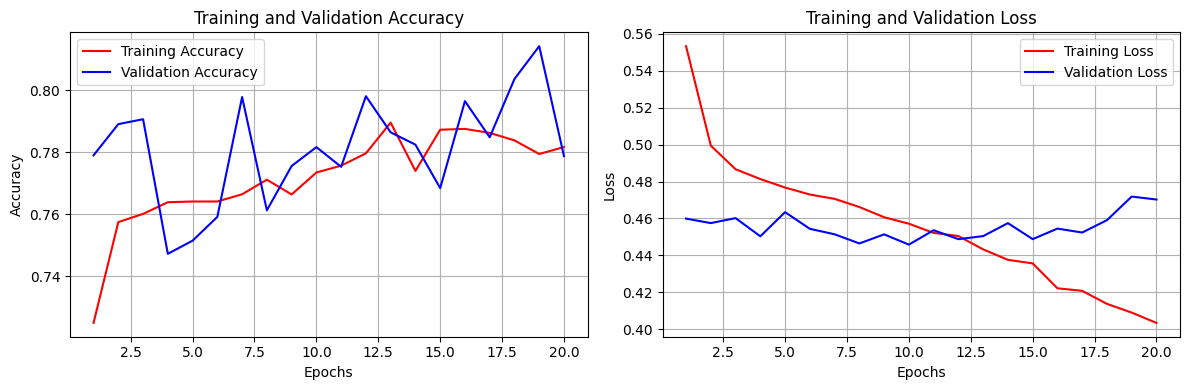

In [129]:
plot_learning_curves(history_attention)

In [130]:
# train and test predictions
attention_y_test_pred = model_attention.predict(X_test_scaled)
attention_y_train_pred = model_attention.predict(X_train_scaled)

print(classification_report(y_test, attention_y_test_pred.round()))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, attention_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, attention_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")



1180/1180 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     10463
         1.0       0.32      0.79      0.45      1333

    accuracy                           0.78     11796
   macro avg       0.64      0.79      0.66     11796
weighted avg       0.89      0.78      0.82     11796

78.63% - Balanced accuracy Test
80.11% - Balanced accuracy Train


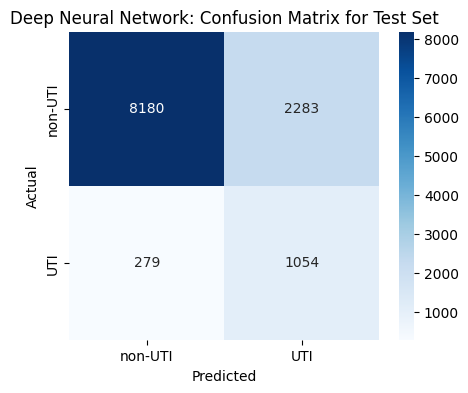

In [131]:
plot_confusion_matrix(y_test, attention_y_test_pred.round(), title='Deep Neural Network: Confusion Matrix for Test Set')

## Random Forest

Optuna Hyperparameter Search

```python
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define range of hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0) if bootstrap else None

    # Create and train classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        class_weight=class_weight,
        max_samples=max_samples,
        random_state=42
    )
    
    return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# Create study object and specify direction is 'maximize' for classification tasks
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust n_trials based on your resources

# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

```

```
Number of finished trials:  100
Best trial:
Value:  0.89253921137945
Params:
    n_estimators: 73
    max_depth: 16
    min_samples_split: 6
    min_samples_leaf: 5
    max_features: auto
    bootstrap: False
    criterion: entropy
    class_weight: None
```

```python
# Retrieve the best hyperparameters
best_params = study.best_params

# Incorporate the best hyperparameters into your RandomForestClassifier
rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the classifier with the training data
rf.fit(X_train_scaled, y_train)
```

```
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     10463
         1.0       0.63      0.07      0.12      1333

    accuracy                           0.89     11796
   macro avg       0.76      0.53      0.53     11796
weighted avg       0.86      0.89      0.85     11796

[66]
0s
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")
output
53.06% - Balanced accuracy Test
68.46% - Balanced accuracy Train
```

In [32]:
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train_scaled, y_train)

# rf_y_pred = rf.predict(X_test_scaled)
# rf_y_train_pred = rf.predict(X_train_scaled)
# print(classification_report(y_test, rf_y_pred))

In [33]:
# using the best parameters
best_param_rf = {'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 83}

rf = RandomForestClassifier(**best_param_rf,random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     10463
         1.0       0.33      0.76      0.46      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.78      0.67     11796
weighted avg       0.89      0.80      0.83     11796

78.44% - Balanced accuracy Test
82.39% - Balanced accuracy Train


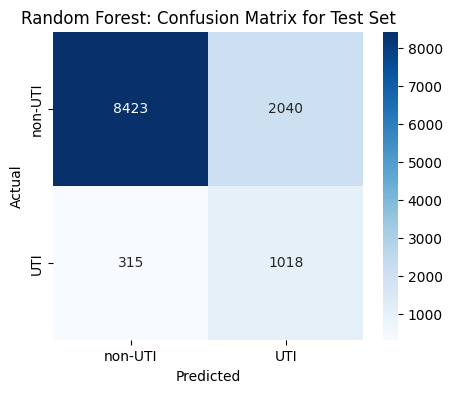

In [34]:
plot_confusion_matrix(y_test, rf_y_pred.round(), title='Random Forest: Confusion Matrix for Test Set')

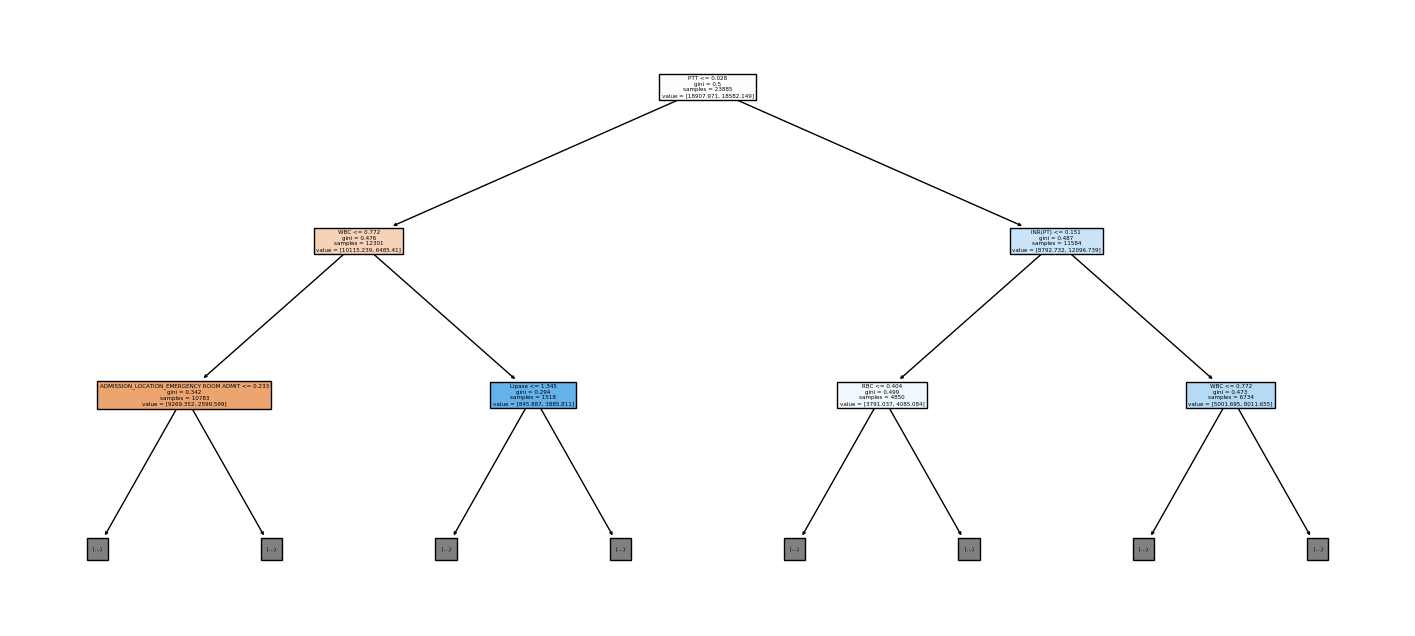

In [35]:
# Visualizing the first decision tree
plt.figure(figsize=(18,8))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

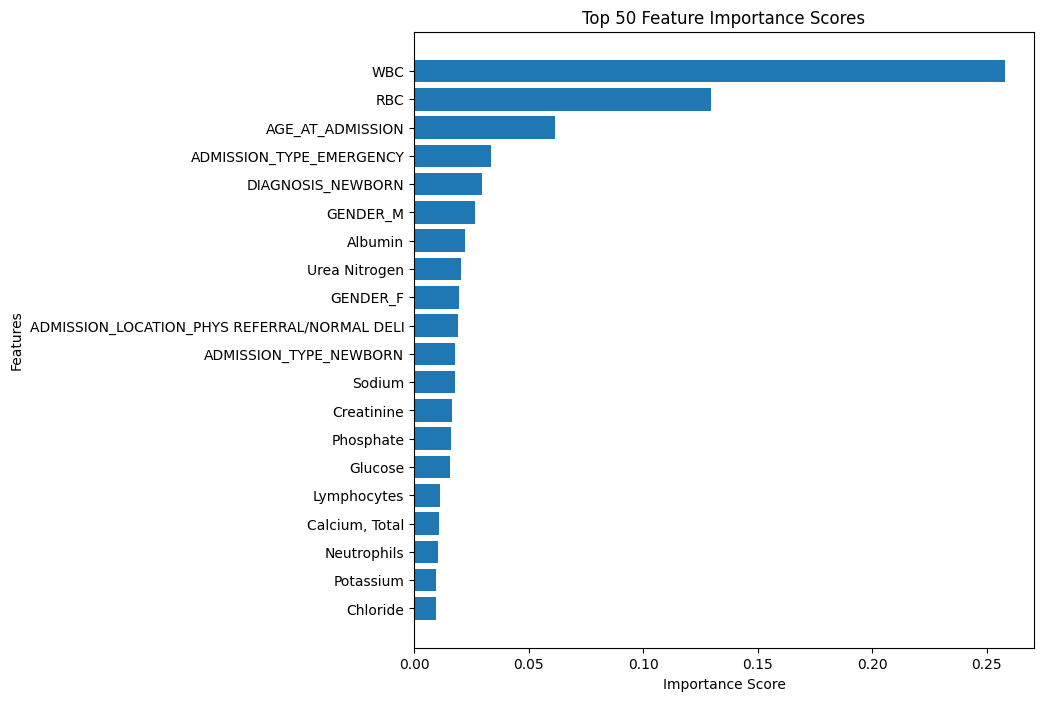

In [36]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top features
sorted_indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,8))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [39]:
# import optuna
# import xgboost as xgb
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define range of hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 2, 25),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.1, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
#         'objective': 'binary:logistic',
#         'random_state': 42
#     }

#     booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
#     if booster == 'dart':
#         params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
#         params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
#         params['rate_drop'] = trial.suggest_float('rate_drop', 0, 1.0)
#         params['skip_drop'] = trial.suggest_float('skip_drop', 0, 1.0)
#     params['booster'] = booster

#     # Create and train classifier
#     clf = xgb.XGBClassifier(**params)

#     return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# # Create study object and specify direction is 'maximize' for classification tasks
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)  # Adjust n_trials based on your resources

# # Results
# best_params = study.best_params
# best_params

# # Use the best hyperparameters to create and train the model
# xgb_model = xgb.XGBClassifier(**best_params, objective="binary:logistic", random_state=42)
# xgb_model.fit(X_train_scaled, y_train)

# # Predict using test and train sets
# xgb_predictions = xgb_model.predict(X_test_scaled)
# xgb_train_predictions = xgb_model.predict(X_train_scaled)

# # Show classification report
# print("XGBoost Classification Report:\n")
# print(classification_report(y_test, xgb_predictions))

In [40]:
# # Create and train the model
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model.fit(X_train_scaled, y_train)

# # predict using test set
# xgb_predictions = xgb_model.predict(X_test_scaled)
# xgb_train_predictions = xgb_model.predict(X_train_scaled)

# # show classification report
# print("XGBoost Classification Report:\n")
# print(classification_report(y_test, xgb_predictions))

In [80]:
# XGBoost best hyperparameters
best_params_xgb_binlog = {'learning_rate': 0.07333333333333333, 'max_depth': 3, 'n_estimators': 450}

# amend for class imbalances
class_weights = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# run on best parameters
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, **best_params_xgb_binlog, scale_pos_weight=class_weights)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.32      0.79      0.45      1333

    accuracy                           0.79     11796
   macro avg       0.64      0.79      0.66     11796
weighted avg       0.89      0.79      0.82     11796

78.71% - Balanced accuracy Test
80.14% - Balanced accuracy Train


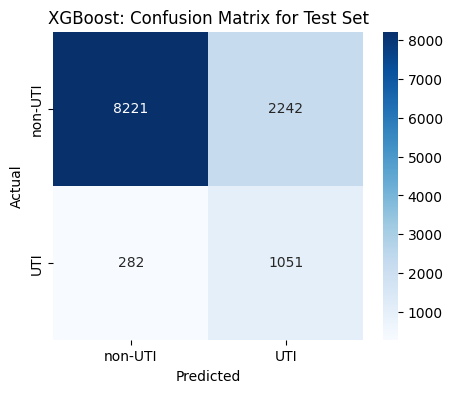

In [81]:
plot_confusion_matrix(y_test, xgb_predictions.round(), title='XGBoost: Confusion Matrix for Test Set')

In [82]:
# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(xgb_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values_obj = explainer(X_test_scaled)

# Extract values from the Explanation object
shap_values_array = shap_values_obj.values

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[top_features]

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)  # Adjust font size
ax1.set_title('Global Feature Importance', fontsize=14)  # Adjust font size
ax1.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Remove the top and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)  # Adjust font size

# Plot typical SHAP values on right using only the top features
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)  # Add title and adjust font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Turn off y-axis ticks and labels for ax2 (SHAP dot plot)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

InvalidModelError: ignored

## LightGBM

Optuna Hyperparameter Search

In [43]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define range of hyperparameters
#     params = {
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_bin': trial.suggest_int('max_bin', 32, 255),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
#         'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10.0, log=True),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 0, 7),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-8, 1.0, log=True),
#         'objective': trial.suggest_categorical('objective', ['binary', 'multiclass', 'cross_entropy', 'cross_entropy_lambda']),
#         'random_state': 42
#     }

#     if params['objective'] == 'multiclass':
#         params['num_class'] = 2

#     # Create and train classifier
#     clf = lgb.LGBMClassifier(**params)

#     return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# # Create study object and specify direction is 'maximize' for classification tasks
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  # Adjust n_trials based on your resources

# # Results
# best_params = study.best_params

# # Use the best hyperparameters to create and train the model
# lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)
# lgb_model.fit(X_train_scaled, y_train)

# # Predict using test and train sets
# lgb_predictions = lgb_model.predict(X_test_scaled)
# lgb_train_predictions = lgb_model.predict(X_train_scaled)

# # Show classification report
# print("LightGBM Classification Report:\n")
# print(classification_report(y_test, lgb_predictions))


In [44]:
# # Create and train the model
# lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
# lgb_model.fit(X_train_scaled, y_train)

# # predict using test set
# lgb_predictions = lgb_model.predict(X_test_scaled)
# lgb_train_predictions = lgb_model.predict(X_train_scaled)

# # show classification report
# print("LightGBM Classification Report:\n")
# print(classification_report(y_test, lgb_predictions))

# # calculate balanced accuracy
# print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
# print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

In [45]:
# LightGBM best hyperparameters
best_params = {'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'metric': 'binary_logloss',
 'min_child_samples': 30,
 'num_leaves': 50,
 'objective': 'binary'}

# fit model with best parameters
lgb_best = lgb.LGBMClassifier(**best_params, scale_pos_weight=class_weights, random_state=42)
lgb_best.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_best.predict(X_test_scaled)
lgb_train_predictions = lgb_best.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     10463
         1.0       0.34      0.76      0.47      1333

    accuracy                           0.81     11796
   macro avg       0.65      0.79      0.68     11796
weighted avg       0.89      0.81      0.84     11796

78.61% - Balanced accuracy Test
87.46% - Balanced accuracy Train


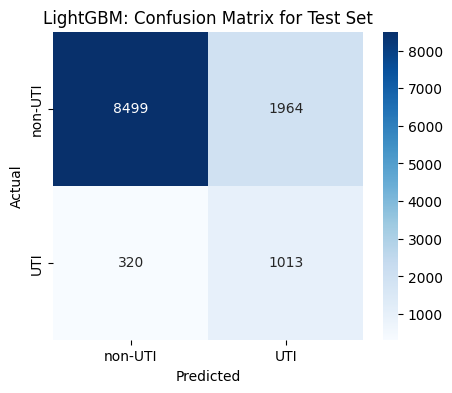

In [46]:
plot_confusion_matrix(y_test, lgb_predictions.round(), title='LightGBM: Confusion Matrix for Test Set')

## Logistic Regression

In [50]:
# import optuna
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define range of hyperparameters
#     params = {
#         'C': trial.suggest_float('C', 1e-4, 10.0, log=True),
#         'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none']),
#         'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
#         'class_weight': 'balanced',
#         'max_iter': 1000,
#         'random_state': 42
#     }

#     if params['penalty'] == 'none':
#         params.pop('solver')  # If penalty is none, solver is set automatically to 'lbfgs'

#     if params['penalty'] == 'elasticnet':
#         params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)

#     # Create and train classifier
#     clf = LogisticRegression(**params)

#     return cross_val_score(clf, X_train_scaled, y_train, n_jobs=-1, cv=3).mean()

# # Create study object and specify direction is 'maximize' for classification tasks
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  # Adjust n_trials based on your resources

# # Results
# best_params = study.best_params

# # Use the best hyperparameters to create and train the model
# logistic_model = LogisticRegression(**best_params, random_state=42, class_weight='balanced', max_iter=1000)
# logistic_model.fit(X_train_scaled, y_train)

# # Predict using test and train sets
# logistic_predictions = logistic_model.predict(X_test_scaled)
# logistic_train_predictions = logistic_model.predict(X_train_scaled)

# # Show classification report
# print("Logistic Regression Classification Report:\n")
# print(classification_report(y_test, logistic_predictions))

In [51]:
# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.32      0.79      0.46      1333

    accuracy                           0.79     11796
   macro avg       0.65      0.79      0.66     11796
weighted avg       0.89      0.79      0.82     11796



In [52]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

78.90% - Balanced accuracy Test
78.06% - Balanced accuracy Train


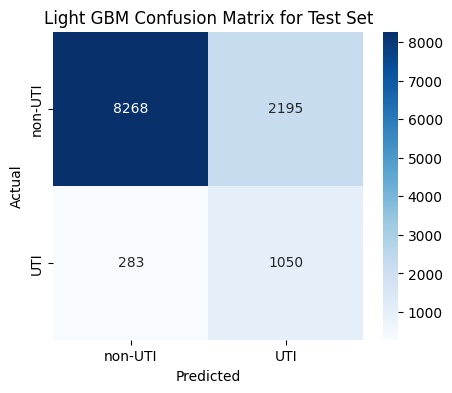

In [53]:
plot_confusion_matrix(y_test, logistic_predictions.round(), title='Light GBM Confusion Matrix for Test Set')

In [ ]:
evaluate_classification(logistic_model, X_test_scaled, y_test)

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


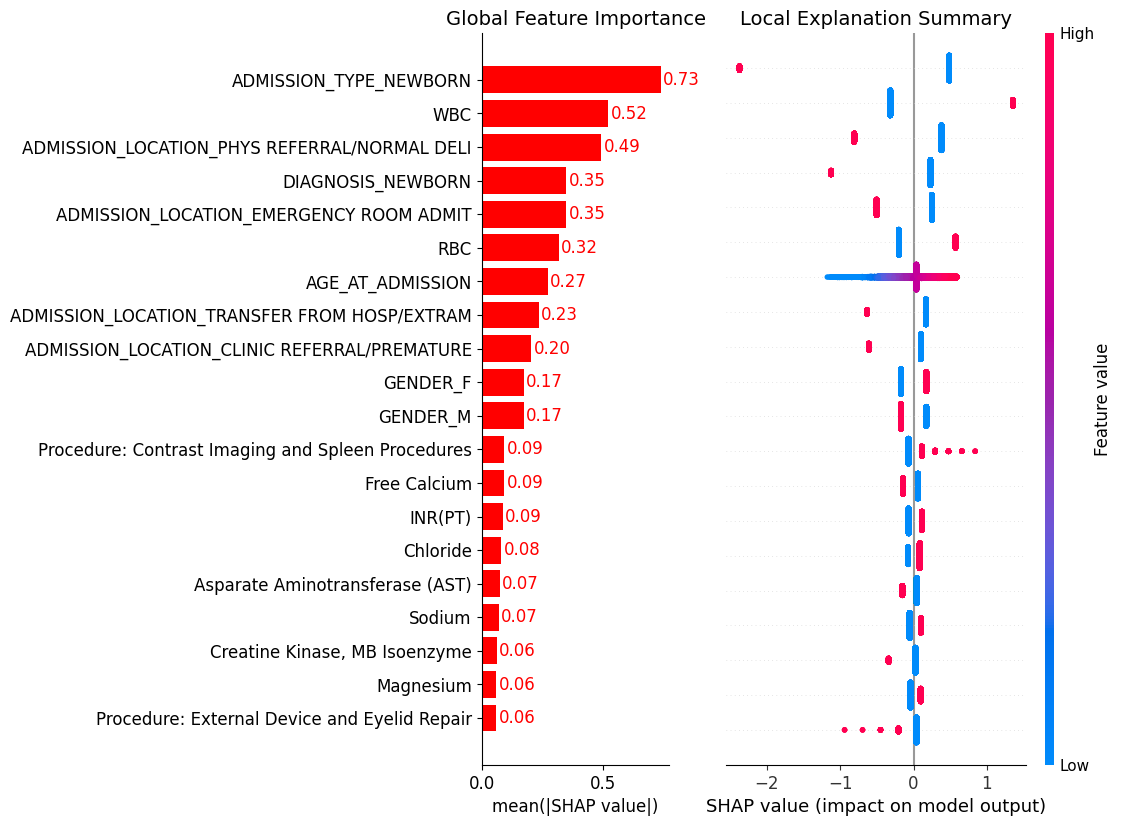

In [54]:
# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values_obj = explainer(X_test_scaled)

# Extract values from the Explanation object
shap_values_array = shap_values_obj.values

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[top_features]

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)  # Adjust font size
ax1.set_title('Global Feature Importance', fontsize=14)  # Adjust font size
ax1.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Remove the top and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)  # Adjust font size

# Plot typical SHAP values on right using only the top features
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)  # Add title and adjust font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Turn off y-axis ticks and labels for ax2 (SHAP dot plot)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output


Feature importance based on SHAP-values. On the left side, the mean absolute SHAP values are depicted, to illustrate global feature importance. On the right side, the local explanation summary shows the direction of the relationship between a variable and target output. Positive SHAP-values are indicative of uti, while negative SHAP-values are indicative of non-uti. As demonstrated by the colorbar, higher values are shown in red, while lower values are shown in blue.

## ROC Curve for all models

369/369 [==============================] - 1s 1ms/step


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


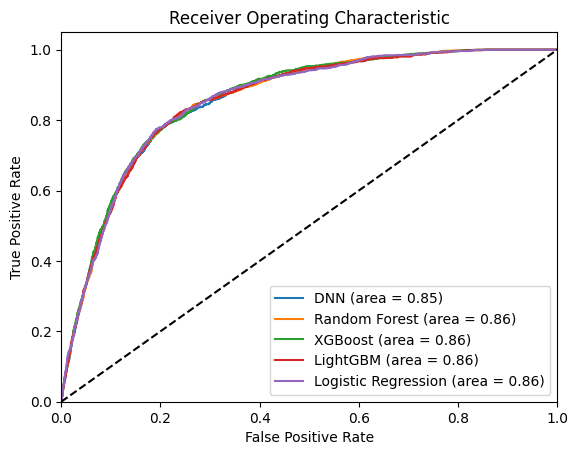

In [56]:
# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Attention DNN
y_pred_attention = model_attention.predict(X_test_scaled).ravel()
fpr_attention, tpr_attention, thresholds_attention = roc_curve(y_test, y_pred_attention)
roc_auc_attention = auc(fpr_attention, tpr_attention)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_best.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_attention, tpr_attention, label=f'DNN (area = {roc_auc_attention:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Best Model =

### Risk Scores

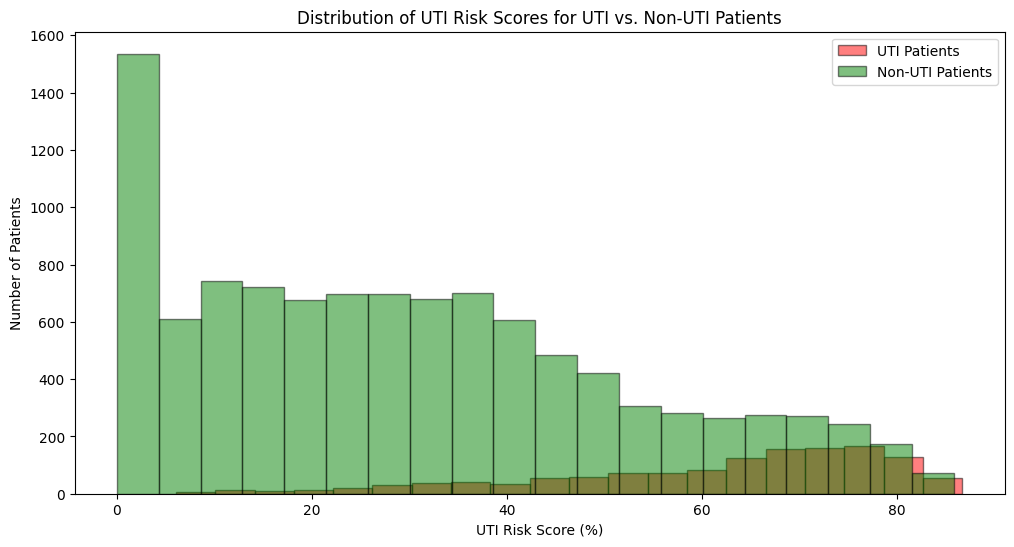

In [37]:
# Predict probabilities
probabilities = rf.predict_proba(X_test_scaled)

# Extract uti risk scores
uti_risk_scores = probabilities[:, 1]
uti_risk_scores_percentage = uti_risk_scores * 100

uti_scores = uti_risk_scores_percentage[y_test == 1]
non_uti_scores = uti_risk_scores_percentage[y_test == 0]

plt.figure(figsize=(12,6))

# Histogram for UTI patients
plt.hist(uti_scores, bins=20, color='red', alpha=0.5, label='UTI Patients', edgecolor='black')

# Histogram for non-UTI patients
plt.hist(non_uti_scores, bins=20, color='green', alpha=0.5, label='Non-UTI Patients', edgecolor='black')

plt.xlabel('UTI Risk Score (%)')
plt.ylabel('Number of Patients')
plt.title('Distribution of UTI Risk Scores for UTI vs. Non-UTI Patients')
plt.legend()
plt.show()


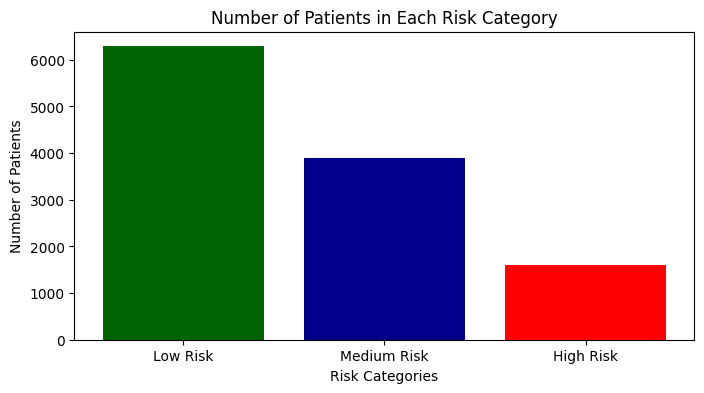

In [38]:
# Risk Categories
categories = ['Low Risk', 'Medium Risk', 'High Risk']
counts = [
    sum(uti_risk_scores_percentage <= 33),
    sum((uti_risk_scores_percentage > 33) & (uti_risk_scores_percentage <= 66)),
    sum(uti_risk_scores_percentage > 66)
]

plt.figure(figsize=(8,4))
plt.bar(categories, counts, color=['darkgreen', 'darkblue', 'red'])
plt.xlabel('Risk Categories')
plt.ylabel('Number of Patients')
plt.title('Number of Patients in Each Risk Category')
plt.show()


## Patient Journey: Plotting Risk Over Time

Plotting Risk Over Time

In [135]:
import gdown
import pandas as pd

url = "https://drive.google.com/uc?id=1gbCOuChLORE3MadTQhqspibN0-_H_546"
output = "ffill_new.csv"
gdown.download(url, output, quiet=False)

ffill_new = pd.read_csv(output)
ffill_new.shape

Downloading...
From: https://drive.google.com/uc?id=1gbCOuChLORE3MadTQhqspibN0-_H_546
To: /content/ffill_new.csv
100%|██████████| 874M/874M [00:03<00:00, 252MB/s]


(2482473, 83)

In [136]:
# Store the TIMESTAMP for later use
timestamps = ffill_new["TIMESTAMP"].copy()
hadmid = ffill_new["HADM_ID"].copy()

# Drop the TIMESTAMP column from the data
ffill_new = ffill_new.drop(columns="TIMESTAMP")
ffill_new = ffill_new.drop(columns="HADM_ID")
ffill_new = ffill_new.drop(columns="uti")

# Now, scale the data
timestamp_scaled = StdScaler.transform(ffill_new)

In [138]:
# Predict to get risk scores
risk_scores = model_attention.predict(timestamp_scaled)
ffill_new["Risk_Scores"] = risk_scores

77578/77578 [==============================] - 133s 2ms/step


In [139]:
# Add the TIMESTAMP column back to new_data
ffill_new["TIMESTAMP"] = timestamps
ffill_new["HADM_ID"] = hadmid

# Filter out rows for a specific ID
sample_HADM_ID = 108957
sample_data = ffill_new[ffill_new['HADM_ID'] == sample_HADM_ID]

In [140]:
sample_data.head()

,Procedure: Surgical Suture and Repair,"Creatine Kinase, MB Isoenzyme",Bands,Lipase,Iron,Procedure: Facial and Thoracic Surgery,"Bilirubin, Total",Procedure: Cranial and Peripheral Interventions,Eosinophils,"Fibrinogen, Functional",ADMISSION_TYPE_ELECTIVE,"Chloride, Whole Blood",Procedure: External Device and Eyelid Repair,"Iron Binding Capacity, Total",Red Blood Cells,Procedure: Gastric Procedure and Vascular Revision,"Sodium, Whole Blood",Monocytes,Transferrin,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,Hematocrit,Procedure: Spinal and Abdominal Surgery,Vancomycin,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Alanine Aminotransferase (ALT),Procedure: Structural and Bone Biopsy,Procedure: Lung Biopsy and Intervention,"Potassium, Whole Blood",ADMISSION_TYPE_NEWBORN,Lactate Dehydrogenase (LD),pCO2,Urobilinogen,pO2,Procedure: Arterial Imaging and Debridement,pH,Anion Gap,Asparate Aminotransferase (AST),Free Calcium,Calculated Total CO2,ETHNICITY_WHITE,PT,Alkaline Phosphatase,Lactate,DIAGNOSIS_NEWBORN,Procedure: Knee and Spinal Surgery,MCV,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,White Blood Cells,Hyaline Casts,Platelet Count,MCH,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,RDW,MCHC,INR(PT),Magnesium,Creatine Kinase (CK),Neutrophils,Lymphocytes,Bicarbonate,Procedure: Injections and Therapeutic Procedures,"Calcium, Total",Glucose,Potassium,PTT,Procedure: Catheterization and Ventilation Techniques,Troponin T,Procedure: Contrast Imaging and Spleen Procedures,Phosphate,Chloride,Sodium,Albumin,Creatinine,GENDER_F,Urea Nitrogen,GENDER_M,ADMISSION_TYPE_EMERGENCY,AGE_AT_ADMISSION,RBC,WBC,Risk_Scores,TIMESTAMP,HADM_ID
215167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.202119,2145-08-09 16:00:00,108957
215168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.202119,2145-08-09 17:00:00,108957
215169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.202119,2145-08-09 18:00:00,108957
215170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.202119,2145-08-09 19:00:00,108957
215171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.202119,2145-08-09 20:00:00,108957


In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


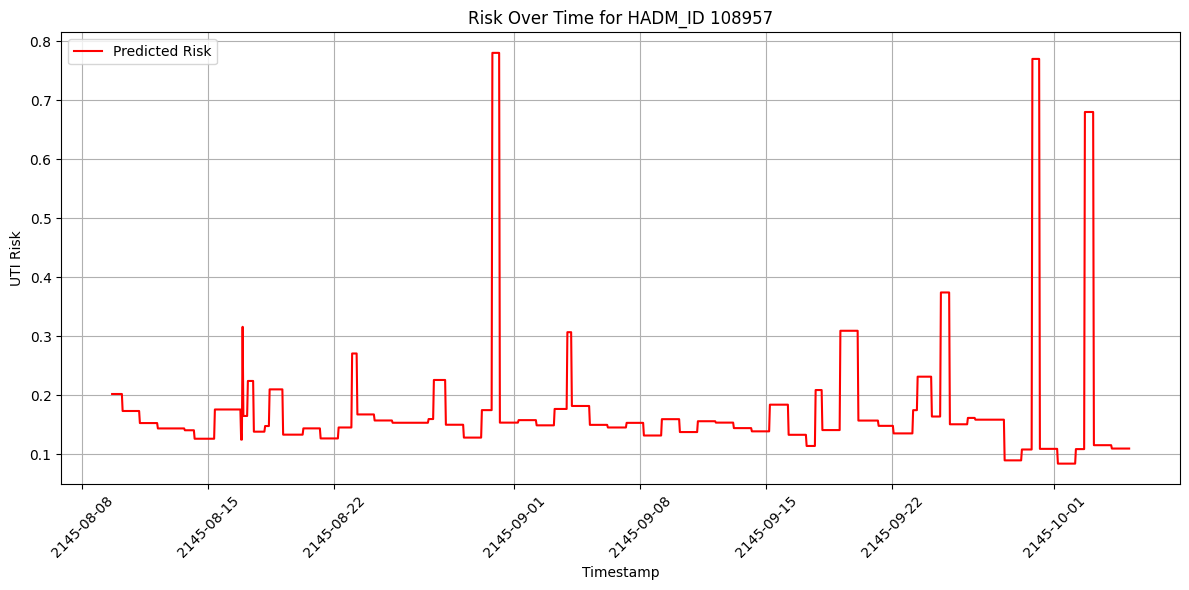

In [153]:
# Reset style to default
plt.style.use('default')

# Convert TIMESTAMP column to datetime
sample_data = sample_data.copy()
sample_data.loc[:, "TIMESTAMP"] = pd.to_datetime(sample_data["TIMESTAMP"])

# Plotting the risk over time
plt.figure(figsize=(12, 6))
plt.plot(sample_data["TIMESTAMP"], sample_data["Risk_Scores"], label='Predicted Risk', color='red')
plt.title(f'Risk Over Time for HADM_ID {sample_HADM_ID}')
plt.xlabel('Timestamp')
plt.ylabel('UTI Risk')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate timestamps for better visibility
plt.tight_layout()
plt.show()


In [148]:
# Select data between 08-28 and 09-01
selected_data = sample_data[(sample_data['TIMESTAMP'] >= '2145-08-30 18:00:00') & (sample_data['TIMESTAMP'] <= '2145-08-31 07:00:00')]
selected_data

,Procedure: Surgical Suture and Repair,"Creatine Kinase, MB Isoenzyme",Bands,Lipase,Iron,Procedure: Facial and Thoracic Surgery,"Bilirubin, Total",Procedure: Cranial and Peripheral Interventions,Eosinophils,"Fibrinogen, Functional",ADMISSION_TYPE_ELECTIVE,"Chloride, Whole Blood",Procedure: External Device and Eyelid Repair,"Iron Binding Capacity, Total",Red Blood Cells,Procedure: Gastric Procedure and Vascular Revision,"Sodium, Whole Blood",Monocytes,Transferrin,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,Hematocrit,Procedure: Spinal and Abdominal Surgery,Vancomycin,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Alanine Aminotransferase (ALT),Procedure: Structural and Bone Biopsy,Procedure: Lung Biopsy and Intervention,"Potassium, Whole Blood",ADMISSION_TYPE_NEWBORN,Lactate Dehydrogenase (LD),pCO2,Urobilinogen,pO2,Procedure: Arterial Imaging and Debridement,pH,Anion Gap,Asparate Aminotransferase (AST),Free Calcium,Calculated Total CO2,ETHNICITY_WHITE,PT,Alkaline Phosphatase,Lactate,DIAGNOSIS_NEWBORN,Procedure: Knee and Spinal Surgery,MCV,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,White Blood Cells,Hyaline Casts,Platelet Count,MCH,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,RDW,MCHC,INR(PT),Magnesium,Creatine Kinase (CK),Neutrophils,Lymphocytes,Bicarbonate,Procedure: Injections and Therapeutic Procedures,"Calcium, Total",Glucose,Potassium,PTT,Procedure: Catheterization and Ventilation Techniques,Troponin T,Procedure: Contrast Imaging and Spleen Procedures,Phosphate,Chloride,Sodium,Albumin,Creatinine,GENDER_F,Urea Nitrogen,GENDER_M,ADMISSION_TYPE_EMERGENCY,AGE_AT_ADMISSION,RBC,WBC,Risk_Scores,TIMESTAMP,HADM_ID
215673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.174798,2145-08-30 18:00:00,108957
215674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.780328,2145-08-30 19:00:00,108957
215675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.780328,2145-08-30 20:00:00,108957
215676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.780328,2145-08-30 21:00:00,108957
215677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.780328,2145-08-30 22:00:00,108957
215678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.780328,2145-08-30 23:00:00,108957
215679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

The risk for the patient notably spiked during the same period when both the White Blood Cell (WBC) and Red Blood Cell (RBC) were recorded as 1 during the timeframe from approximately 2145-08-30 19:00:00 to 2145-08-31 04:00:00.